# About
This notebook aims to train an XGBoost model to solve a regression problem. The model, if well trained, will be able to predict **monthly rental prices** for homes in Brazil given input features such as city, floor area, number of bathrooms, animals/no animals allowed, homeowners associate fee, property tax, and fire insurance. The below figure shows the predictions made, along with their residuals (predicted - actual rental price)<br>
![Alt text](img/residplot.png)

# Import Libraries and Load Data

In [326]:
import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import gaussian_kde

In [6]:
REGION = boto3.Session().region_name
DATA_HOST = f"sagemaker-example-files-prod-{REGION}"
DATA_PATH = "datasets/tabular/brazil_houses/"
ARCHIVE_NAME = "kaggle_brazil_houses_rental_data.csv"

In [7]:
# download dataset to notebook instance
s3 = boto3.client('s3')
s3.download_file(DATA_HOST,DATA_PATH+ARCHIVE_NAME,ARCHIVE_NAME)

In [122]:
df = pd.read_csv(ARCHIVE_NAME)

# EDA
## Data Cleaning
### Null Values | Transforming Feature Dtypes

In [123]:
print("dataset shape:",df.shape)

dataset shape: (10692, 13)


In [124]:
# null values
df.isna().any(axis=1).sum()

0

In [125]:
df.dtypes

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

In [126]:
# why is floor column of object dtype?
floor_object_mask = pd.to_numeric(df['floor'],errors='coerce').isna()
df[floor_object_mask].head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955
15,Campinas,330,4,6,6,-,acept,furnished,680,8000,328,121,9129
19,São Paulo,600,4,5,6,-,acept,not furnished,0,12000,9500,181,21680
20,São Paulo,100,7,4,0,-,acept,not furnished,0,3800,118,58,3976
23,São Paulo,35,1,1,0,-,acept,not furnished,0,1100,3,14,1117


In [127]:
# there are too many non-numeric floor values for us to get rid of these training examples
print(f"{len(df[floor_object_mask])/len(df):.0%} of our dataset contains invalid floor values")

23% of our dataset contains invalid floor values


In [128]:
# impute with "-1"
df.loc[floor_object_mask,'floor'] = -1
# convert to numerical dtype
df['floor'] = pd.to_numeric(df['floor'])

In [129]:
# explore categorical features
cat_feat = ['animal','furniture']
for col in cat_feat:
    print(col)
    print(df[col].value_counts(),"\n")

animal
animal
acept        8316
not acept    2376
Name: count, dtype: int64 

furniture
furniture
not furnished    8086
furnished        2606
Name: count, dtype: int64 



In [130]:
# one-hot encode categorical features
df['animal'] = df['animal'].astype('category').cat.codes
df['furniture'] = df['furniture'].astype('category').cat.codes
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,0,0,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,0,1,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,0,1,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,0,1,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,1,1,0,800,25,11,836


### Check for Anomalies
Our model does not train as well when there are anomalies so we must identify and deal with them appropriately.

In [131]:
# descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
area,10692.0,149.217920,537.016942,11.0,56.00,90.0,182.0,46335.0
rooms,10692.0,2.506079,1.171266,1.0,2.00,2.0,3.0,13.0
bathroom,10692.0,2.236813,1.407198,1.0,1.00,2.0,3.0,10.0
parking spaces,10692.0,1.609147,1.589521,0.0,0.00,1.0,2.0,12.0
floor,10692.0,4.837823,6.272465,-1.0,1.00,3.0,8.0,301.0
animal,10692.0,0.222222,0.415759,0.0,0.00,0.0,0.0,1.0
furniture,10692.0,0.756266,0.429354,0.0,1.00,1.0,1.0,1.0
hoa (R$),10692.0,1174.021698,15592.305248,0.0,170.00,560.0,1237.5,1117000.0
rent amount (R$),10692.0,3896.247194,3408.545518,450.0,1530.00,2661.0,5000.0,45000.0
property tax (R$),10692.0,366.704358,3107.832321,0.0,38.00,125.0,375.0,313700.0


In [132]:
# the maximum value for hoa (R$) is extreme. find examples where hoa (R$) is high whilst rent amount (R$) is relatively low
mask = (df['hoa (R$)']>3*df['rent amount (R$)']) 
df[mask]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
255,Belo Horizonte,155,1,4,0,4,1,1,1117000,2790,64,38,1120000
984,São Paulo,293,4,3,3,5,0,1,3300,1050,500,14,4864
1444,Porto Alegre,42,1,1,0,10,0,1,32000,700,40,11,32750
2859,São Paulo,285,4,5,4,6,0,0,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,0,0,81150,4500,9900,58,95610
3987,Rio de Janeiro,223,3,3,0,15,1,1,2409,765,350,10,3534
4966,São Paulo,290,4,4,4,1,0,1,4900,1000,1659,13,7572
5293,São Paulo,850,5,7,8,1,1,1,14000,4000,0,51,18050
6230,São Paulo,340,5,4,2,7,0,1,220000,12000,1000,153,233200
6979,Belo Horizonte,155,1,4,0,4,1,1,1117000,2790,64,38,1120000


In [133]:
# drop these rows
df=df[~mask]

In [134]:
# the maximum value for property tax (R$) is extreme. find examples where hoa (R$) is high whilst rent amount (R$) is relatively low
mask = (df['property tax (R$)']>3*df['rent amount (R$)']) 
df[mask]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
5331,São Paulo,300,4,5,5,6,1,1,3500,1990,10830,26,16350
6243,Rio de Janeiro,95,2,2,1,11,0,1,1024,3000,28120,39,32180
6645,São Paulo,42,1,2,1,6,1,1,690,2500,313700,32,316900


In [135]:
# drop these rows
df=df[~mask]

In [137]:
# drop homes with unreasonable floor area (larger than 5000m2)
mask = df['area']>5000
print(df[mask])
df = df[~mask]

                city   area  ...  fire insurance (R$)  total (R$)
2397  Belo Horizonte  46335  ...                  114       10220
5915       São Paulo  24606  ...                  103       18320
9241        Campinas  12732  ...                   21        2417

[3 rows x 13 columns]


In [138]:
def plot_features(df,cols):
    """
    Plotting function to plot a histogram and boxplot for each feature in variable 'cols'
    """
    for col in cols:
        fig,axs = plt.subplots(1,2,figsize=(12,4))
        axs[0].set_title(f"{col} - Distribution")
        sns.histplot(df,x=col,ax=axs[0])
    
        axs[1].set_title(f"{col} - Outlier Check")
        sns.boxplot(df,x=col,ax=axs[1])

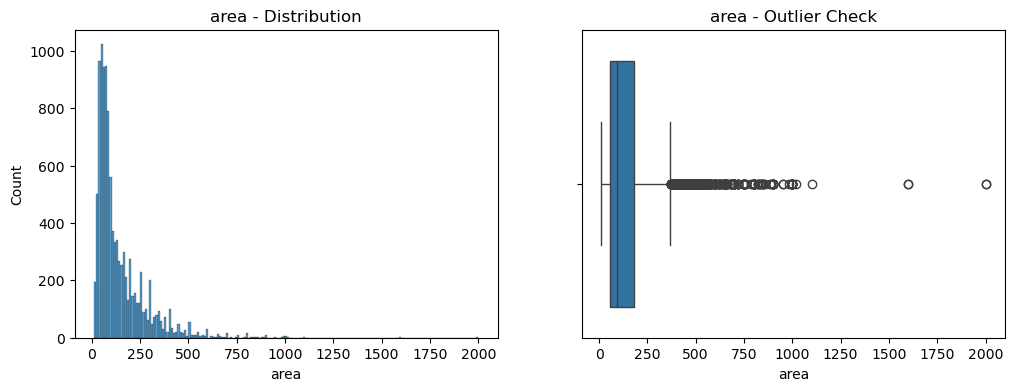

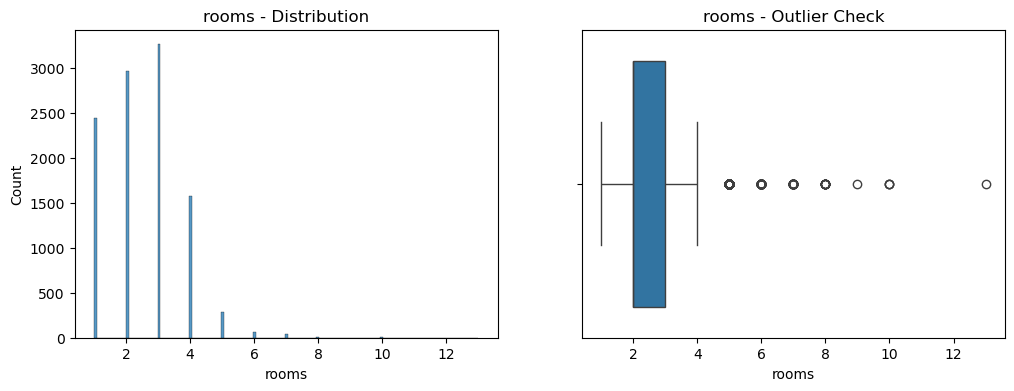

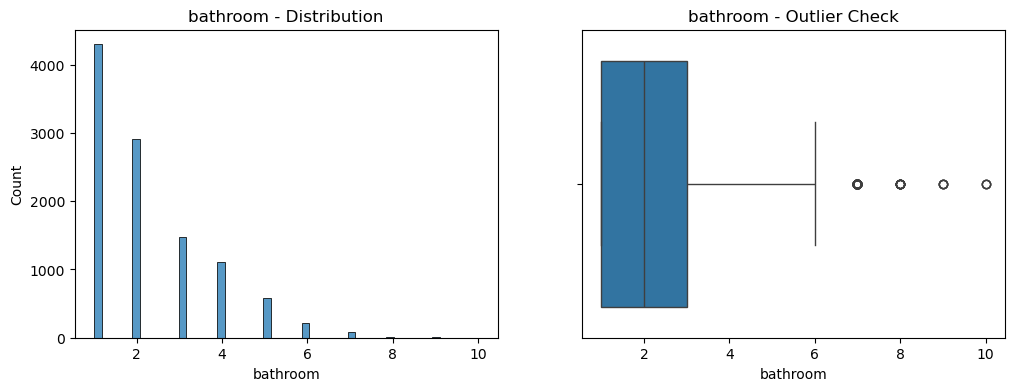

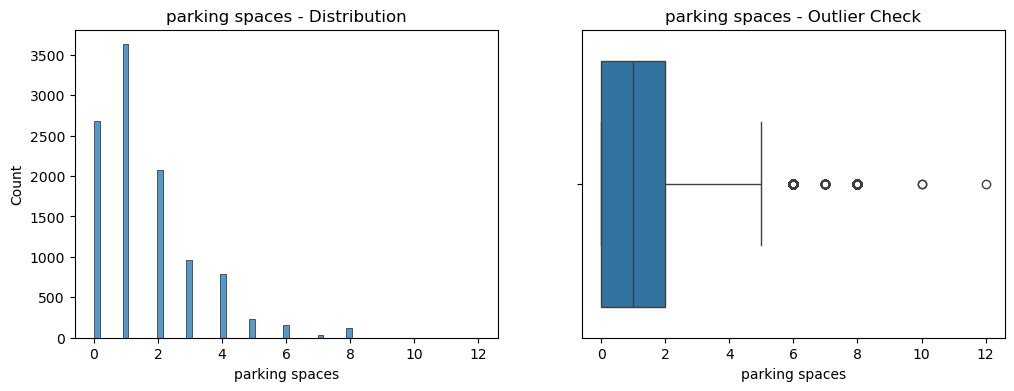

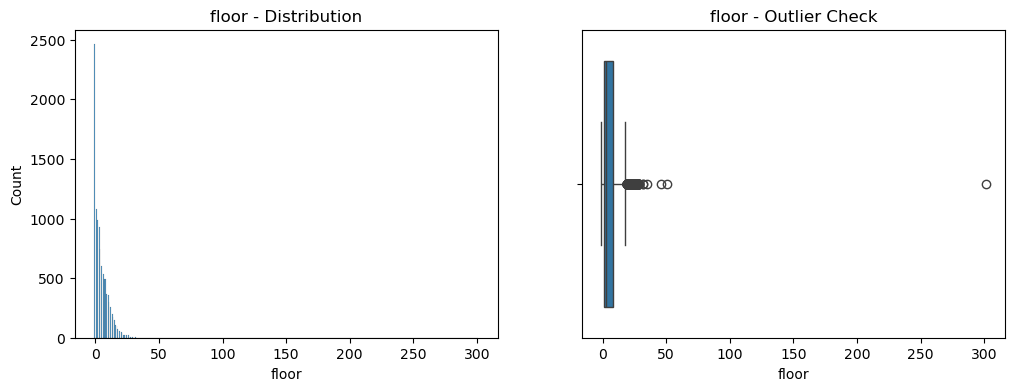

In [139]:
cols = ['area', 'rooms', 'bathroom', 'parking spaces', 'floor']
plot_features(df,cols)

In [140]:
# floor feature is likely the floor level of a home; the outlier at floor>300 is very likely invalid
df=df[df['floor']<300]

In [168]:
# one-hot encode city feature
dummies = pd.get_dummies(df['city']).astype(int)
df=pd.concat([df,dummies],axis=1).drop(columns='city')

### Scale Data
You don't need to scale data for tree algorithms

## Shuffle & Train-Validation Split
We will reserve and allocate 20% of our dataset to the validation dataset, to evaluate how our model performs on unseen data. 

In [183]:
features = ['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal',
       'furniture', 'hoa (R$)', 'property tax (R$)',
       'fire insurance (R$)', 'total (R$)', 'Belo Horizonte', 'Campinas',
       'Porto Alegre', 'Rio de Janeiro', 'São Paulo']
target = ['rent amount (R$)']

In [194]:
# Sagemaker XGBoost assumes the targets are first column so we must reorder columns
df = df[target+features]

# train-test split: 80%-20%
train_data, val_data = train_test_split(df,test_size=0.2,shuffle=True,random_state=24)
print("Train Set Size: ", train_data.shape)
print("Validation Set Size: ", val_data.shape)

Train Set Size:  (8539, 17)
Validation Set Size:  (2135, 17)


# Sagemaker: Training, Deploying and Making Predictions
## Upload Data to S3
Sagemaker requires data to be in a S3 bucket to start a training job. We will be using the default behaviour of "File mode" which means training does not commence until all data has been transferred from S3 to our training instance volumes (as is the recommended mode for XGBoost). This is preferred over "Pipe mode" because data is streamed in sequentially and cannot be reread very easily.

In [193]:
# create a new bucket
bucket_name = "sagemaker-brasil-house-price-predictor"
s3.create_bucket(Bucket=bucket_name,
                 CreateBucketConfiguration={'LocationConstraint': 'eu-north-1'})

{'ResponseMetadata': {'RequestId': 'KDYGHCXAYH4ZVP0M',
  'HostId': 'Es0QqtyD20t1r/U+Fk0MoLDs9TWd5PuwIReXEeTGK0b1JcXtGriND3C418PpX9xCysXVTKnLmZq07kRki2vcnzZ+b6pWe3NE',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Es0QqtyD20t1r/U+Fk0MoLDs9TWd5PuwIReXEeTGK0b1JcXtGriND3C418PpX9xCysXVTKnLmZq07kRki2vcnzZ+b6pWe3NE',
   'x-amz-request-id': 'KDYGHCXAYH4ZVP0M',
   'date': 'Mon, 22 Sep 2025 15:57:18 GMT',
   'location': 'http://sagemaker-brasil-house-price-predictor.s3.amazonaws.com/',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': 'http://sagemaker-brasil-house-price-predictor.s3.amazonaws.com/'}

In [203]:
# save as csv and upload to s3 bucket
train_data.to_csv("tmp.csv",index=False,header=False)
train_obj_key = 'data/train/data.csv'
s3.upload_file("tmp.csv",bucket_name,train_obj_key)

val_data.to_csv("tmp.csv",index=False,header=False)
val_obj_key = 'data/val/data.csv'
s3.upload_file("tmp.csv",bucket_name,val_obj_key)

## Define and Train Model
Let us train our model for a small number of epochs.

In [211]:
# output path where the traines model will be saved
object_key='model/xgb_model'
s3_output_location=f's3://{bucket_name}/{object_key}'

# look for XGBoost image URI and build an XGBoost container
xgboost_container = image_uris.retrieve(framework='xgboost',region=boto3.Session().region_name,version='1.7-1')

# hyperparameters for XGBoost algorithm
hyperparameters = {
    "num_round":5, # number of epochs
    "verbosity":0,
    "objective":"reg:squarederror"
}

# construct an XGBoost estimator from this container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m5.large',
                                          volume_size=5,
                                          output_path=s3_output_location)

# define content type and paths to training and validation datasets
content_type = 'text/csv' # IMPORTANT; default content type XGBoost expects is text/libsvm
train_input = TrainingInput("s3://{}/{}".format(bucket_name,train_obj_key),content_type=content_type)
val_input = TrainingInput("s3://{}/{}".format(bucket_name,val_obj_key),content_type=content_type)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [212]:
# execute training job
estimator.fit({'train':train_input,'validation':val_input})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-09-22-16-41-45-382


2025-09-22 16:41:48 Starting - Starting the training job...
2025-09-22 16:42:02 Starting - Preparing the instances for training...
2025-09-22 16:42:25 Downloading - Downloading input data...
2025-09-22 16:43:10 Downloading - Downloading the training image......
2025-09-22 16:44:21 Training - Training image download completed. Training in progress.../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-09-22 16:44:24.914 ip-10-0-243-25.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-09-22 16:44:24.996 ip-10-0-243-25.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-09-22:16:44:25:INFO] Imported framework sage

## Running a Tuning Job
The hyperparameters used above are the default values for this algorithm (e.g. what AWS thinks are good values), but we can do better than this. We can orchestrate multiple training jobs (which may or may not run in parallel depending on your configuration) to find the optimal set of hyperparameters which will yield the most accurate model. This process of running multiple training jobs is known as a **tuning job**

In [215]:
# tuning job config
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.5",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "10",
          "MinValue": "2",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "3",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:rmse",
      "Type": "Minimize"
    },
    "RandomSeed" : 123
  }    

In [219]:
xgboost_image = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1.7-1')

s3_input_train = "s3://{}/{}".format(bucket_name,train_obj_key)
s3_input_validation ="s3://{}/{}".format(bucket_name,val_obj_key)

model_obj_key = "model/tuning_job/xgboost"
s3_output_path = "s3://{}/{}".format(bucket_name,model_obj_key)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": xgboost_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": s3_output_path
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.m5.large",
      "VolumeSizeInGB": 5
    },
    "RoleArn": sagemaker.get_execution_role(),
    "StaticHyperParameters": {
      "eval_metric": "rmse",
      "num_round": "50",
      "objective": "reg:squarederror"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 3600 # 1hr
    }
}

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [221]:
sm = boto3.client("sagemaker")
tuning_job_name = "ATuningJob"
sm.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-north-1:263108256547:hyper-parameter-tuning-job/ATuningJob',
 'ResponseMetadata': {'RequestId': '03538997-7d6a-44d9-8fb0-cf287cc3cddf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '03538997-7d6a-44d9-8fb0-cf287cc3cddf',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '112',
   'date': 'Mon, 22 Sep 2025 17:21:31 GMT'},
  'RetryAttempts': 0}}

You can view the status of your training jobs in the AWS Management Console: <br>
IMAGE!!!

In [229]:
best_training_job = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['BestTrainingJob']
print("Best Training Job:",best_training_job['TrainingJobName'],"\n\nTuned Hyperparameters:\n",best_training_job['TunedHyperParameters'])

Best Training Job: ATuningJob-014-b492e7b6 

Tuned Hyperparameters:
 {'eta': '0.31543618623445235', 'max_depth': '8', 'min_child_weight': '2.0'}


Interesting, our tuning job landed to a similar conclusion as AWS for the 'eta' parameter (AWS: eta=0.3) but the latter two parameters are more noticeably different (AWS: max_depth=6, min_child_weight=1.0)

## Batch Transform Job with Best Model
Instead of deploying our model to an endpoint, we will opt for the cheaper inference option (batch transform).This means we are only billed for the runtime of the inference job. <p> Despite running the tuning job and having model artifacts saved in S3, we haven't yet created our model. This is the first step.

In [247]:
from sagemaker.xgboost.model import XGBoostModel

In [254]:
# define s3 path to model artifacts
training_job_info = sm.describe_training_job(TrainingJobName=best_training_job['TrainingJobName'])
model_artifacts_path = training_job_info['ModelArtifacts']['S3ModelArtifacts']

# create model 
xgb_model = XGBoostModel(
    model_data=model_artifacts_path,
    framework_version="1.7-1",
    role=sagemaker.get_execution_role()
)


In [255]:
# define the batch transform job
transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    # strategy="SingleRecord",   # or 'MultiRecord' if your input is large
    # assemble_with="Line",      # join multiple outputs with newlines
    output_path=f"s3://{bucket_name}/output/batch-transform/"
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-09-22-19-48-33-560


Our batch transform job is ready, all that is left is to prepare some input data and upload to s3.

In [261]:
# drop target column
val_data_for_inference = val_data.drop(columns='rent amount (R$)')

# save locally
val_data_for_inference.to_csv('tmp.csv',index=False,header=False)

# upload to s3
inf_obj_key = 'data/inf/data'
s3.upload_file('tmp.csv',bucket_name,inf_obj_key)

In [263]:
# # run transform job 
# transformer.transform(
#     data="s3://{}/{}".format(bucket_name,inf_obj_key),  # input data without labels
#     content_type="text/csv"
# )

# # wait until job completes
# transformer.wait()

It turns out my account-level quota for batch transform is limited to 0 ml.m5.large instances. I have requested for an increase. In the meantime...
## Deploy Best Model to Serverless Endpoint

In [270]:
# deploy to serverless endpoint
predictor=xgb_model.deploy(
    serverless_inference_config=ServerlessInferenceConfig(max_concurrency=2),
    serializer=CSVSerializer()
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-09-22-20-13-14-269
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2025-09-22-20-13-14-729
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2025-09-22-20-13-14-729


-----------------------------------!

In [273]:
# make predictions 
response = predictor.predict(val_data_for_inference)

In [291]:
# add predictions to df
val_data_copy = val_data
# new column
val_data['Predicted Rent (R$)'] = np.array(response).flatten()
# rename target column
val_data = val_data.rename(columns={'rent amount (R$)':'Actual Rent (R$)'})
# convert object to float dtype
val_data['Predicted Rent (R$)']=pd.to_numeric(val_data['Predicted Rent (R$)'])
# calculate residuals
val_data['Residual'] = val_data['Predicted Rent (R$)']-val_data['Actual Rent (R$)']

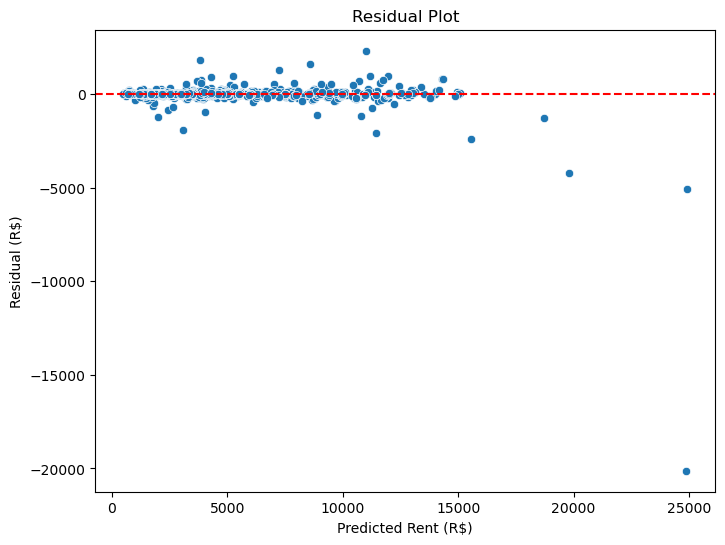

In [308]:
plt.figure(figsize=(8,6))
sns.scatterplot(val_data,x='Predicted Rent (R$)',y='Residual')
plt.axhline(0,color='red',linestyle='--')
plt.title("Residual Plot")
plt.ylabel("Residual (R$)")
plt.show()

In [314]:
high_rent = 15000
print(f"{len(train_data[train_data['rent amount (R$)']>high_rent])/len(train_data):.1%} of the training set had actual rent above {high_rent}")

0.1% of the training set had actual rent above 15000


We can't expect our model to accurately predict rental prices that are above 15000 R$ since it barely sees training examples in this range.

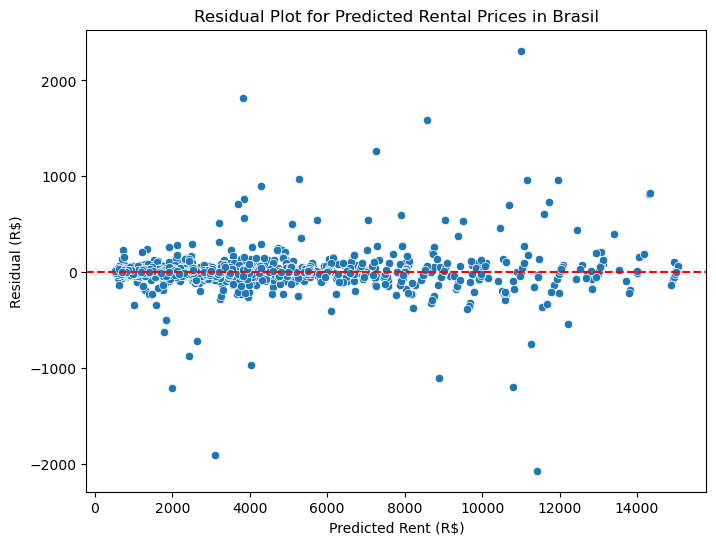

In [373]:
# if we ignore validation examples with actual rent above 15000
mask = val_data['Actual Rent (R$)']<=high_rent
val_data_masked = val_data[mask]

plt.figure(figsize=(8,6))
sns.scatterplot(val_data_masked,x='Predicted Rent (R$)',y='Residual')
plt.axhline(0,color='red',linestyle='--')
plt.title("Residual Plot for Predicted Rental Prices in Brasil")
plt.ylabel("Residual (R$)")
plt.savefig("residplot2.png",dpi=300)
plt.show()

Of course this is very congested, let's highlight which decile each residual lies in so it's clear exactly how well our model is doing.

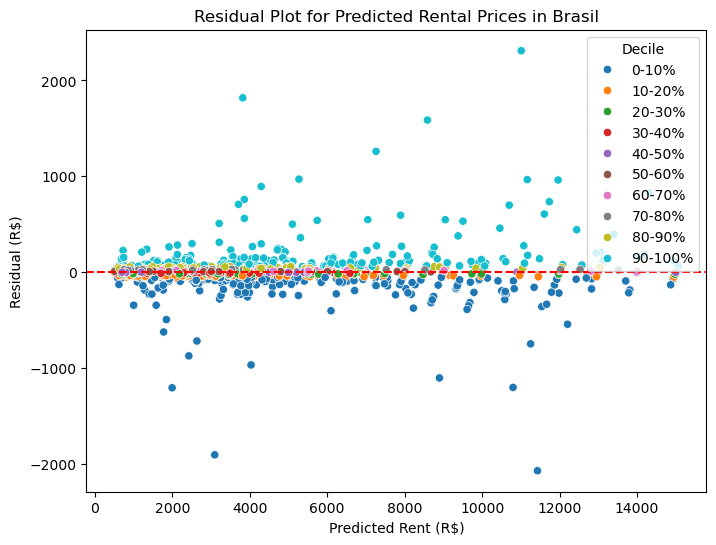

In [371]:
# create deciles from the residual column
labels = [f"{i*10}-{(i+1)*10}%" for i in range(10)]
deciles = pd.qcut(val_data_masked['Residual'],q=np.linspace(0,1,11),labels=labels)
val_data_masked.loc[:, 'Decile'] = deciles

# plot
plt.figure(figsize=(8,6))
sns.scatterplot(val_data_masked,x='Predicted Rent (R$)',y='Residual',hue='Decile')
plt.axhline(0,color='red',linestyle='--')
plt.title("Residual Plot for Predicted Rental Prices in Brasil")
plt.ylabel("Residual (R$)")
plt.savefig("residplot.png",dpi=300)
plt.show()

In [378]:
no_examples = len(val_data)
for limit in [100,50,25]:
    mask = (val_data['Residual']<limit) & (val_data['Residual']>-limit)
    print(f"{len(val_data[mask])/no_examples:.1%} of examples are predicted to within {limit} R$ of the actual rental price")

89.6% of examples are predicted to within 100 R$ of the actual rental price
77.2% of examples are predicted to within 50 R$ of the actual rental price
56.6% of examples are predicted to within 25 R$ of the actual rental price


## Clean Up
Don't forget to also clean up the S3 bucket, CloudWatch Logs and any IAM roles that were created.

In [323]:
xgb_model.delete_model()

INFO:sagemaker:Deleting model with name: sagemaker-xgboost-2025-09-22-20-13-14-269


In [324]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2025-09-22-20-13-14-729
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2025-09-22-20-13-14-729
